# Implementation of of simple Neural Network in TensorFlow

In [1]:
# import modules
%pylab inline

import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import tensorflow as tf
from scipy.misc import imread

Populating the interactive namespace from numpy and matplotlib


In [2]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [3]:
# give path of files
data_dir = 'datasets\mnist'
print(data_dir)

datasets\mnist


In [4]:
# load dataset
train = pd.read_csv(os.path.join(data_dir, 'Train', 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'Test.csv'))

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


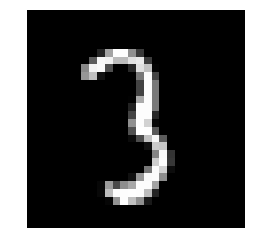

In [5]:
# display sample image
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)

img = imread(filepath, flatten = True)
pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [6]:
# load whole dataset 
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

temp = []
for img_name in test.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
test_x = np.stack(temp)

In [7]:
# create validation dataset
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train.label.values[:split_size], train.label.values[split_size:]

In [8]:
# helper functions
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    
    return temp_batch

def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, input_num_units)
    batch_x = preproc(batch_x)
    
    if dataset_name == 'train':
        batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
        batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y

In [9]:
### set all variables

# number of neurons in each layer
input_num_units = 28*28
hidden_num_units = 50
output_num_units = 10

# define placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])

# set remaining variables
epochs = 5
batch_size = 128
learning_rate = 0.01

### define weights and biases of the neural network 

weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units], seed=seed))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed))
}

In [10]:
# define neural network
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

In [11]:
# define cost function and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [12]:
# define function to initialize variables
init = tf.global_variables_initializer()

In [13]:
with tf.Session() as sess:
    # create initialized variables
    sess.run(init)
    
    ### for each epoch, do:
    ###   for each batch, do:
    ###     create pre-processed batch
    ###     run optimizer by feeding batch
    ###     find cost and reiterate to minimize
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            
            avg_cost += c / total_batch
            
        print( "Epoch:", (epoch+1), "cost =", "{:.5f}".format(avg_cost))
    
    print( "\nTraining complete!")
    
    
    # find predictions on val set
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print( "Validation Accuracy:", accuracy.eval({x: val_x.reshape(-1, input_num_units), y: dense_to_one_hot(val_y)}))
    
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x: test_x.reshape(-1, input_num_units)})

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Epoch: 1 cost = 3.72324
Epoch: 2 cost = 0.55932
Epoch: 3 cost = 0.32360
Epoch: 4 cost = 0.24259
Epoch: 5 cost = 0.18176

Training complete!
Validation Accuracy: 0.911905


Prediction is:  8


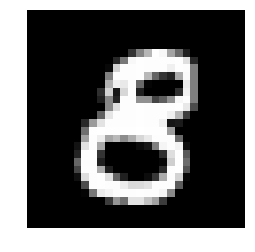

In [14]:
img_name = rng.choice(test.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)

img = imread(filepath, flatten=True)

test_index = int(img_name.split('.')[0]) - 49000

print( "Prediction is: ", pred[test_index])

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

## Building an MLP with TFLearn

In [15]:
import tflearn

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [16]:
train_x = train_x.reshape(-1, input_num_units)
val_x = val_x.reshape(-1, input_num_units)
test_x = test_x.reshape(-1, input_num_units)

In [17]:
train_x /= train_x.max()
val_x /= val_x.max()
test_x /= test_x.max()

In [18]:
# one hot encode outputs
train_y = dense_to_one_hot(train_y)
val_y = dense_to_one_hot(val_y)

In [19]:
tf.reset_default_graph()

In [20]:
# create model
input_layer = tflearn.input_data(shape=[None, 784])
# dense layer
model = tflearn.fully_connected(input_layer, 50, activation='relu')
# Fully Connected Layer
model = tflearn.fully_connected(model, 10, activation='softmax')
lin_reg = tflearn.regression(model, optimizer='adam', loss='categorical_crossentropy',learning_rate=0.05)

In [21]:
# train model
model = tflearn.DNN(lin_reg)
model.fit(train_x, train_y, n_epoch=2, batch_size=128, show_metric=True)

Training Step: 535  | total loss: 0.22810 | time: 0.999s
| Adam | epoch: 002 | loss: 0.22810 - acc: 0.9346 -- iter: 34176/34300
Training Step: 536  | total loss: 0.23130 | time: 1.003s
| Adam | epoch: 002 | loss: 0.23130 - acc: 0.9349 -- iter: 34300/34300
--


In [22]:
model.evaluate(val_x, val_y)

[0.91748299326215477]

## Exercise

Visualize model in tensorboard

In [28]:
model = tflearn.DNN(lin_reg, tensorboard_verbose=3, tensorboard_dir='tflearn')

## Hyperparameters to look out for in Neural Networks

I feel that, hyperparameter tuning is the hardest in neural network in comparison to any other machine learning algorithm. You would be insane to apply Grid Search, as there are numerous parameters when it comes to tuning a neural network.

![](image_5.png)

Some important parameters to look out for while optimizing neural networks are:

* Type of architecture
* Number of Layers
* Number of Neurons in a layer
* Regularization parameters
* Learning Rate
* Type of optimization / backpropagation technique to use
* Dropout rate
* Weight sharing

Also, there may be many more hyperparameters depending on the type of architecture. For example, if you use a convolutional neural network, you would have to look at hyperparameters like convolutional filter size, pooling value, etc.

The best way to pick good parameters is to understand your problem domain. Research the previously applied techniques on your data, and most importantly  ask experienced people for insights to the problem. It’s the only way you can try to ensure you get a “good enough” neural network model.

## Getting your hands dirty

### Round 0: Train for more iterations

In [31]:
tf.reset_default_graph()

# create model
input_layer = tflearn.input_data(shape=[None, 784])
# dense layer
model = tflearn.fully_connected(input_layer, 50, activation='relu')
# Fully Connected Layer
model = tflearn.fully_connected(model, 10, activation='softmax')
model = tflearn.regression(model, optimizer='adam', loss='categorical_crossentropy',learning_rate=0.05)

# train model
model = tflearn.DNN(model)
model.fit(train_x, train_y, n_epoch=10, batch_size=128, show_metric=True)
print('Validation accuracy is', model.evaluate(val_x, val_y))

Training Step: 2679  | total loss: 0.54715 | time: 1.046s
| Adam | epoch: 010 | loss: 0.54715 - acc: 0.8912 -- iter: 34176/34300
Training Step: 2680  | total loss: 0.52327 | time: 1.052s
| Adam | epoch: 010 | loss: 0.52327 - acc: 0.8982 -- iter: 34300/34300
--
Validation accuracy is [0.91993197277289673]


### Round 1: Increase the number of neurons

Let’s start our tweaking! Lets change our model to be “wide”, i.e. increase the number of neurons in our hidden layer

In [32]:
tf.reset_default_graph()

# create model
input_layer = tflearn.input_data(shape=[None, 784])
# dense layer
model = tflearn.fully_connected(input_layer, 500, activation='relu')
# Fully Connected Layer
model = tflearn.fully_connected(model, 10, activation='softmax')
model = tflearn.regression(model, optimizer='adam', loss='categorical_crossentropy',learning_rate=0.05)

# train model
model = tflearn.DNN(model)
model.fit(train_x, train_y, n_epoch=10, batch_size=128, show_metric=True)
print('Validation accuracy is', model.evaluate(val_x, val_y))

Training Step: 2679  | total loss: 0.58672 | time: 2.233s
| Adam | epoch: 010 | loss: 0.58672 - acc: 0.8733 -- iter: 34176/34300
Training Step: 2680  | total loss: 0.56278 | time: 2.239s
| Adam | epoch: 010 | loss: 0.56278 - acc: 0.8758 -- iter: 34300/34300
--
Validation accuracy is [0.90523809520565734]


### Round 2: Increase the number of layers

Now instead of “wide”, we try making our model “deep”. We add four more hidden layers with 50 neurons each

In [35]:
tf.reset_default_graph()

# create model
input_layer = tflearn.input_data(shape=[None, 784])
# dense layers
model = tflearn.fully_connected(input_layer, 50, activation='relu')
model = tflearn.fully_connected(model, 50, activation='relu')
model = tflearn.fully_connected(model, 50, activation='relu')
# Fully Connected Layer
model = tflearn.fully_connected(model, 10, activation='softmax')
model = tflearn.regression(model, optimizer='adam', loss='categorical_crossentropy',learning_rate=0.05)

# train model
model = tflearn.DNN(model)
model.fit(train_x, train_y, n_epoch=10, batch_size=128, show_metric=True)
print('Validation accuracy is', model.evaluate(val_x, val_y))

Training Step: 2679  | total loss: 0.85119 | time: 1.710s
| Adam | epoch: 010 | loss: 0.85119 - acc: 0.7971 -- iter: 34176/34300
Training Step: 2680  | total loss: 0.86786 | time: 1.717s
| Adam | epoch: 010 | loss: 0.86786 - acc: 0.7955 -- iter: 34300/34300
--
Validation accuracy is [0.82741496585664298]


### Round 3: Add regularization

Looks like we didn’t get what we expected. This may be because our model may be overfitting. To deal with this, we use a method called dropout. Dropout is essentially randomly turning off parts of the model so that it does not “overlearn” a concept (To read more about dropout, check out the article on core concepts of neural networks)

In [50]:
tf.reset_default_graph()

# create model
input_layer = tflearn.input_data(shape=[None, 784])
# dense layers
model = tflearn.fully_connected(input_layer, 50, activation='relu')
model = tflearn.dropout(model, 0.9)

model = tflearn.fully_connected(model, 50, activation='relu')
model = tflearn.dropout(model, 0.9)

model = tflearn.fully_connected(model, 50, activation='relu')
model = tflearn.dropout(model, 0.9)

# Fully Connected Layer
model = tflearn.fully_connected(model, 10, activation='softmax')
model = tflearn.regression(model, optimizer='adam', loss='categorical_crossentropy',learning_rate=0.05)

# train model
model = tflearn.DNN(model)
model.fit(train_x, train_y, n_epoch=10, batch_size=128, show_metric=True)
print('Validation accuracy is', model.evaluate(val_x, val_y))

Training Step: 2679  | total loss: 1.39336 | time: 1.081s
| Adam | epoch: 010 | loss: 1.39336 - acc: 0.5103 -- iter: 34176/34300
Training Step: 2680  | total loss: 1.36953 | time: 1.085s
| Adam | epoch: 010 | loss: 1.36953 - acc: 0.5139 -- iter: 34300/34300
--
Validation accuracy is [0.61843537403612725]


### Round 4: Try everything!

Let’s try another thing, we make our model both deep and wide! We should implement all the tweaks that we learnt before. For the purpose of getting faster results, you can reduce the training epochs.

In [51]:
tf.reset_default_graph()

# create model
input_layer = tflearn.input_data(shape=[None, 784])
# dense layers
model = tflearn.fully_connected(input_layer, 100, activation='relu')
model = tflearn.dropout(model, 0.9)

model = tflearn.fully_connected(model, 70, activation='relu')
model = tflearn.dropout(model, 0.9)

model = tflearn.fully_connected(model, 30, activation='relu')
model = tflearn.dropout(model, 0.9)

# Fully Connected Layer
model = tflearn.fully_connected(model, 10, activation='softmax')
model = tflearn.regression(model, optimizer='adam', loss='categorical_crossentropy',learning_rate=0.001)

# train model
model = tflearn.DNN(model)
model.fit(train_x, train_y, n_epoch=100, batch_size=128, show_metric=True)
print('Validation accuracy is', model.evaluate(val_x, val_y))

Training Step: 26799  | total loss: 0.00999 | time: 1.522s
| Adam | epoch: 100 | loss: 0.00999 - acc: 0.9987 -- iter: 34176/34300
Training Step: 26800  | total loss: 0.00934 | time: 1.528s
| Adam | epoch: 100 | loss: 0.00934 - acc: 0.9989 -- iter: 34300/34300
--
Validation accuracy is [0.97285714267873435]
